# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Load and Preprocess dataset

In [2]:
df = pd.read_csv('Biotech_preprocessed_dataset_with_outliers.csv')
df['Time'] = pd.to_datetime(df['Time'])
df['Date'] = df['Time'].dt.date
df.set_index('Date', inplace=True)
df

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-01-04,2024-01-04 15:00:00,15:00:00,15,Thursday,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 16:00:00,16:00:00,16,Thursday,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 17:00:00,17:00:00,17,Thursday,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 18:00:00,18:00:00,18,Thursday,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 19:00:00,19:00:00,19,Thursday,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,2024-07-08 05:00:00,05:00:00,5,Monday,1040.0,635.0,259.0,146.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 06:00:00,06:00:00,6,Monday,1414.0,1023.0,251.0,140.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 07:00:00,07:00:00,7,Monday,571.0,225.0,243.0,103.0,False,True,False,False,False,False,False,False


In [3]:
df.describe()

,Time,Hour,Total (W),Phase_A (W),Phase_B (W),Phase_C (W)
count,4459,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000
mean,2024-04-06 12:00:00,11.499439,1159.329895,586.073111,372.809823,200.400987
min,2024-01-04 15:00:00,0.000000,316.000000,63.000000,94.000000,45.000000
25%,2024-02-20 01:30:00,5.000000,733.000000,271.000000,238.000000,121.000000
50%,2024-04-06 12:00:00,11.000000,943.000000,418.000000,306.000000,183.000000
75%,2024-05-22 22:30:00,18.000000,1314.500000,748.000000,395.000000,187.000000
max,2024-07-08 09:00:00,23.000000,7054.000000,6390.000000,2248.000000,3682.000000
std,NaN,6.926661,767.035561,608.340687,252.884904,177.315925


In [4]:
df_holiday = df[df['Holiday'] == True]
df_holiday

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-01-06,2024-01-06 00:00:00,00:00:00,0,Saturday,732.0,196.0,349.0,187.0,False,False,True,False,False,False,False,True
2024-01-06,2024-01-06 01:00:00,01:00:00,1,Saturday,1226.0,612.0,428.0,186.0,False,False,True,False,False,False,False,True
2024-01-06,2024-01-06 02:00:00,02:00:00,2,Saturday,593.0,81.0,325.0,187.0,False,False,True,False,False,False,False,True
2024-01-06,2024-01-06 03:00:00,03:00:00,3,Saturday,1148.0,644.0,317.0,187.0,False,False,True,False,False,False,False,True
2024-01-06,2024-01-06 04:00:00,04:00:00,4,Saturday,655.0,81.0,386.0,188.0,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-06,2024-07-06 19:00:00,19:00:00,19,Saturday,1667.0,1085.0,445.0,137.0,False,False,True,False,False,False,False,True
2024-07-06,2024-07-06 20:00:00,20:00:00,20,Saturday,1628.0,1141.0,338.0,149.0,False,False,True,False,False,False,False,True
2024-07-06,2024-07-06 21:00:00,21:00:00,21,Saturday,1013.0,482.0,385.0,146.0,False,False,True,False,False,False,False,True


In [5]:
df_office_day = df[df['Holiday'] == False]
df_office_day

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-01-04,2024-01-04 15:00:00,15:00:00,15,Thursday,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 16:00:00,16:00:00,16,Thursday,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 17:00:00,17:00:00,17,Thursday,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 18:00:00,18:00:00,18,Thursday,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 19:00:00,19:00:00,19,Thursday,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,2024-07-08 05:00:00,05:00:00,5,Monday,1040.0,635.0,259.0,146.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 06:00:00,06:00:00,6,Monday,1414.0,1023.0,251.0,140.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 07:00:00,07:00:00,7,Monday,571.0,225.0,243.0,103.0,False,True,False,False,False,False,False,False


<Axes: xlabel='Date'>

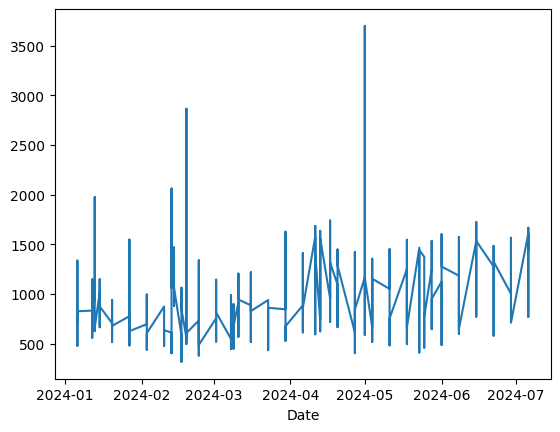

In [6]:
df_holiday['Total (W)'].plot()

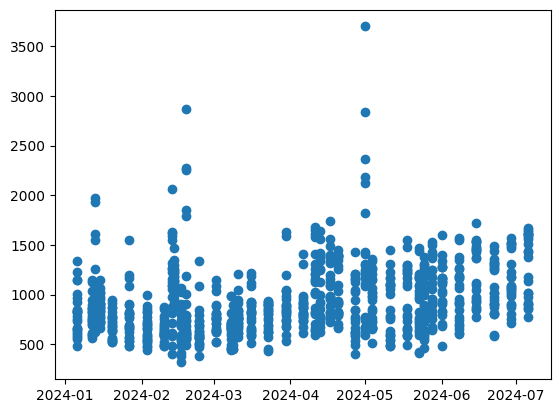

In [7]:
plt.scatter(df_holiday.index, df_holiday['Total (W)'])
plt.show()

<Axes: xlabel='Date'>

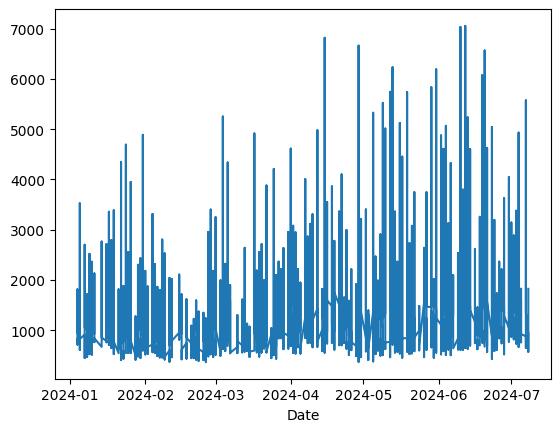

In [8]:
df_office_day['Total (W)'].plot()

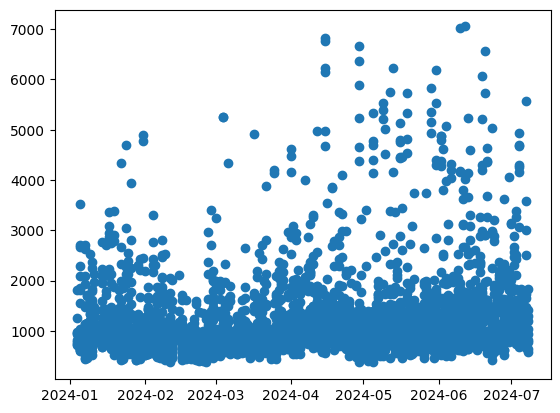

In [9]:
plt.scatter(df_office_day.index, df_office_day['Total (W)'])
plt.show()

In [10]:
print(df_holiday['Total (W)'].mean())
print(df_office_day['Total (W)'].mean())

922.5694444444445
1222.2330400227079


**Drop Unnecessary columns** \
We are going to forecast total load based only on the previous values of total load. So, we wiil keep only the 'Total (W)' column.

In [11]:
df_office_day = pd.DataFrame(df_office_day['Total (W)'])
df_office_day

,Total (W)
Date,
2024-01-04,821.0
2024-01-04,741.0
2024-01-04,776.0
2024-01-04,1260.0
2024-01-04,973.0
...,...
2024-07-08,1040.0
2024-07-08,1414.0
2024-07-08,571.0


In [12]:
df_holiday = pd.DataFrame(df_holiday['Total (W)'])
df_holiday

,Total (W)
Date,
2024-01-06,732.0
2024-01-06,1226.0
2024-01-06,593.0
2024-01-06,1148.0
2024-01-06,655.0
...,...
2024-07-06,1667.0
2024-07-06,1628.0
2024-07-06,1013.0


**Scaling**

In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_office_day = scaler.fit_transform(df_office_day)
df_office_day = pd.DataFrame(df_office_day, columns=['Total (W)'])
df_office_day

,Total (W)
0,-0.865051
1,-0.888989
2,-0.878516
3,-0.733692
4,-0.819569
...,...
3518,-0.799521
3519,-0.687612
3520,-0.939856
3521,-0.876122


# Separate train and test data

In [14]:
training_data_len = int(len(df_office_day)*0.8)
validation_data_len = int(len(df_office_day)*0.1)
print(training_data_len)
print(validation_data_len)

train_data = df_office_day[:training_data_len]
validation_data = df_office_day[training_data_len:training_data_len+validation_data_len]
test_data = df_office_day[training_data_len+validation_data_len:]


print(train_data.shape, validation_data.shape, test_data.shape)

2818
352
(2818, 1) (352, 1) (353, 1)


In [15]:
print(train_data['Total (W)'].mean())
print(validation_data['Total (W)'].mean())
print(test_data['Total (W)'].mean())

-0.7649600393129744
-0.654974906153093
-0.6753602107608039


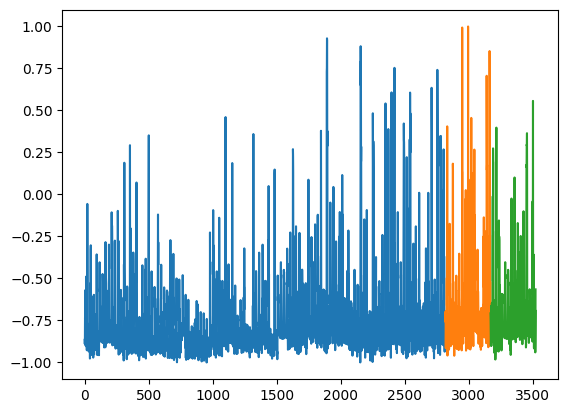

In [16]:
plt.plot(train_data['Total (W)'])
plt.plot(validation_data['Total (W)'])
plt.plot(test_data['Total (W)'])
plt.show()

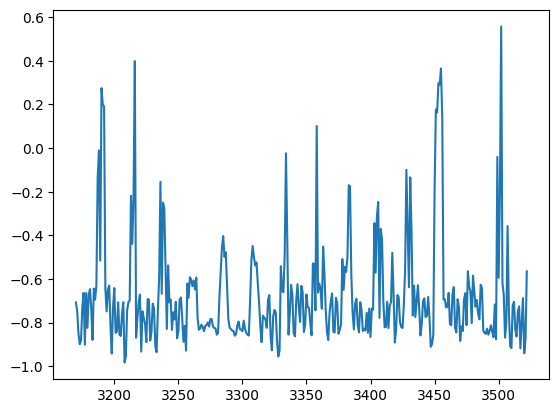

In [17]:
plt.plot(test_data['Total (W)'])
plt.show()

In [18]:
dataset_train = train_data['Total (W)'].values
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape


(2818, 1)

In [19]:
dataset_validation = validation_data['Total (W)'].values
dataset_validation = np.reshape(dataset_validation, (-1, 1))
dataset_validation.shape

(352, 1)

In [20]:
dataset_test = test_data['Total (W)'].values
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(353, 1)

**Create Sequences**

In [21]:
scaled_train, scaled_validation, scaled_test = dataset_train, dataset_validation, dataset_test

In [22]:
sequence_length = 24
X_train, y_train = [], []
for i in range(len(scaled_train)-sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((2794, 24, 1), (2794, 24, 1))

In [23]:
X_validation, y_validation = [], []
for i in range(len(scaled_validation)-sequence_length):
  X_validation.append(scaled_validation[i:i+sequence_length])
  y_validation.append(scaled_validation[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_validation, y_validation = np.array(X_validation), np.array(y_validation)

X_validation.shape, y_validation.shape

((328, 24, 1), (328, 24, 1))

In [24]:
X_test, y_test = [], []
for i in range(len(scaled_test)-sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])
  # y_test.append(scaled_test[i+sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test.shape, y_test.shape

((329, 24, 1), (329, 24, 1))

**Convert to Tensors**

In [25]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)
print(X_validation.shape, y_validation.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)


torch.Size([2794, 24, 1]) torch.Size([2794, 24, 1])
torch.Size([328, 24, 1]) torch.Size([328, 24, 1])
torch.Size([329, 24, 1]) torch.Size([329, 24, 1])


# Create Model

In [26]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.0)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out)
    return out


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [28]:
input_size = 1
num_layers = 1
hidden_size = 4
output_size = 1

model = LSTM(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


**Torch Dataloader**

In [29]:
batch_size = 16
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(X_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [30]:
for x, y in train_loader:
	print(f'X shape: {x.shape}, y shape: {y.shape}')
	break

X shape: torch.Size([16, 24, 1]), y shape: torch.Size([16, 24, 1])


# Train the Model

In [31]:
num_epochs = 40
train_loss_hist =[]
validation_loss_hist =[]
train_mape_hist = []
validation_mape_hist = []
# Training loop
for epoch in range(num_epochs):
	total_loss_train = 0.0
	total_mape_train = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		# predictions = predictions[:, -1, :]
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss_train += loss.item()
		total_mape_train += torch.mean(torch.abs((predictions[:, -1, :] - batch_y[:, -1, :])/(batch_y[:, -1, :]+1e-8)))*100.0

	# Calculate average training loss and accuracy
	average_loss_train = total_loss_train / len(train_loader)
	train_loss_hist.append(average_loss_train)
	average_mape_train = total_mape_train / len(train_loader)
	train_mape_hist.append(average_mape_train)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_loss_validation = 0.0
		total_mape_validation = 0.0

		for batch_X_validation, batch_y_validation in validation_loader:
			batch_X_validation, batch_validation = batch_X_validation.to(device), batch_y_validation.to(device)
			predictions_validation = model(batch_X_validation)
			# predictions_validation = predictions_validation[:, -1, :]
			validation_loss = loss_fn(predictions_validation, batch_y_validation)

			total_mape_validation += torch.mean(torch.abs((predictions_validation[:, -1, :] - batch_y_validation[:, -1, :])/(batch_y_validation[:, -1, :]+1e-8)))*100.0
			total_loss_validation += validation_loss.item()

		# Calculate average test loss and accuracy
		average_loss_validation = total_loss_validation / len(validation_loader)
		validation_loss_hist.append(average_loss_validation)
		average_mape_validation = total_mape_validation / len(validation_loader)
		validation_mape_hist.append(average_mape_validation)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss_train:.4f}, Validation Loss: {average_loss_validation:.4f}')


Epoch [10/40] - Training Loss: 0.0354, Validation Loss: 0.0687
Epoch [20/40] - Training Loss: 0.0345, Validation Loss: 0.0690
Epoch [30/40] - Training Loss: 0.0337, Validation Loss: 0.0695
Epoch [40/40] - Training Loss: 0.0334, Validation Loss: 0.0705


In [32]:
for i in range(len(train_mape_hist)):
  if (i+1) % 10 == 0:
    print(f'Epoch {i+1} - Training MAPE: {train_mape_hist[i]:.2f}, Test MAPE: {validation_mape_hist[i]:.2f}')

Epoch 10 - Training MAPE: 30.60, Test MAPE: 65.41
Epoch 20 - Training MAPE: 30.17, Test MAPE: 59.14
Epoch 30 - Training MAPE: 29.76, Test MAPE: 62.60
Epoch 40 - Training MAPE: 29.88, Test MAPE: 63.71


In [33]:
train_mapes = []
for i in range(len(train_mape_hist)):
  train_mapes.append(train_mape_hist[i].item())

validation_mapes = []
for i in range(len(validation_mape_hist)):
  validation_mapes.append(validation_mape_hist[i].item())

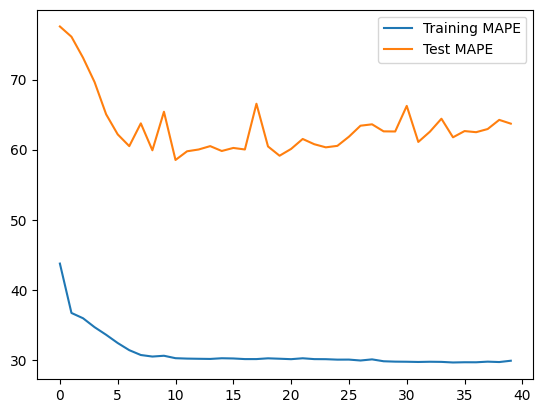

In [34]:
plt.plot(train_mapes, label="Training MAPE")
plt.plot(validation_mapes, label="Validation MAPE")
plt.legend()
plt.show()

# Test the Model

**Actual vs Predicted Power on Test Data**

In [65]:
actuals_test = np.array([])
predictions_test = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        predictions = model(batch_X_test)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_test = np.append(predictions_test, predictions[:, -1])

        actuals =  batch_y_test.to('cpu').numpy().squeeze()
        actuals_test = np.append(actuals_test, actuals[:, -1])


In [71]:
# MAPE on test data
relative_abs_error = abs((actuals_test-predictions_test)/actuals_test)
print(f"MAPE on test data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on test data = 43.29


In [67]:
actuals_test = np.expand_dims(actuals_test, axis=1)
actuals_test_original = scaler.inverse_transform(actuals_test)

predictions_test = np.expand_dims(predictions_test, axis=1)
predictions_test_original = scaler.inverse_transform(predictions_test)

pd.DataFrame({'Predicted Power':predictions_test_original.squeeze(), 'Actual Power': actuals_test_original.squeeze()})

,Predicted Power,Actual Power
0,1200.765644,1211.000076
1,1057.433597,1545.999938
2,1096.806818,1606.999966
3,1114.921154,992.999982
4,939.734642,566.999967
...,...,...
324,926.942498,1039.999924
325,1109.882223,1413.999909
326,1323.289392,571.000077
327,892.052443,784.000084


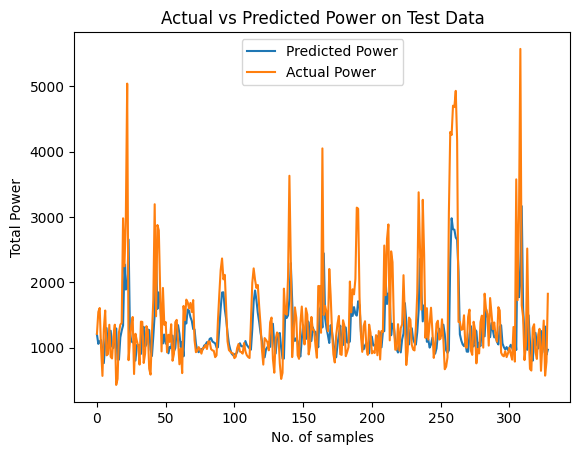

In [79]:
plt.plot(predictions_test_original, label='Predicted Power')
plt.plot(actuals_test_original, label='Actual Power')
plt.title('Actual vs Predicted Power on Test Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

**Re-evaluate Model on Training Data**

In [76]:
actuals_train = np.array([])
predictions_train = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_train, batch_y_train in train_loader:
        batch_X_train, batch_y_train = batch_X_train.to(device), batch_y_train.to(device)
        predictions = model(batch_X_train)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_train = np.append(predictions_train, predictions[:, -1])

        actuals =  batch_y_train.to('cpu').numpy().squeeze()
        actuals_train = np.append(actuals_train, actuals[:, -1])


In [77]:
# MAPE on training data
relative_abs_error = abs((actuals_train-predictions_train)/actuals_train)
print(f"MAPE on train data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on train data = 29.69


In [78]:
actuals_train = np.expand_dims(actuals_train, axis=1)
actuals_train_original = scaler.inverse_transform(actuals_train)

predictions_train = np.expand_dims(predictions_train, axis=1)
predictions_train_original = scaler.inverse_transform(predictions_train)

pd.DataFrame({'Predicted Power':predictions_train_original.squeeze(), 'Actual Power': actuals_train_original.squeeze()})

,Predicted Power,Actual Power
0,850.251986,379.999975
1,872.826181,762.999957
2,1133.764954,1357.999969
3,739.496301,784.000084
4,1088.110997,624.000084
...,...,...
2789,1116.615139,370.999978
2790,788.127681,558.999947
2791,934.891125,573.000032
2792,1567.108828,1120.999902


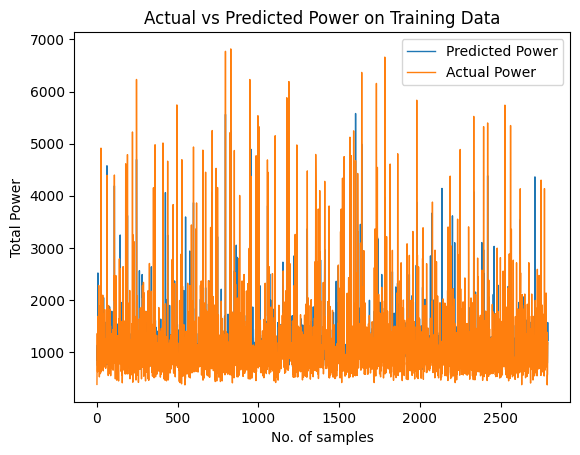

In [84]:
plt.plot(predictions_train_original, label='Predicted Power', linewidth=1)
plt.plot(actuals_train_original, label='Actual Power', linewidth=1)
plt.title('Actual vs Predicted Power on Training Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

**Re-evaluate Model on Validation Dataset**

In [85]:
actuals_validation = np.array([])
predictions_validation = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_validation, batch_y_validation in validation_loader:
        batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
        predictions = model(batch_X_validation)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_validation = np.append(predictions_validation, predictions[:, -1])

        actuals =  batch_y_validation.to('cpu').numpy().squeeze()
        actuals_validation = np.append(actuals_validation, actuals[:, -1])


In [86]:
# MAPE on validation dataset
relative_abs_error = abs((actuals_validation-predictions_validation)/actuals_validation)
print(f"MAPE on validation data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on validation data = 63.70


In [87]:
actuals_validation = np.expand_dims(actuals_validation, axis=1)
actuals_validation_original = scaler.inverse_transform(actuals_validation)

predictions_validation = np.expand_dims(predictions_validation, axis=1)
predictions_validation_original = scaler.inverse_transform(predictions_validation)

pd.DataFrame({'Predicted Power':predictions_validation_original.squeeze(), 'Actual Power': actuals_validation_original.squeeze()})

,Predicted Power,Actual Power
0,1838.428245,2534.000007
1,1149.550856,992.999982
2,1030.696946,1087.000066
3,1278.440995,1148.000093
4,1167.549456,1402.999956
...,...,...
323,1139.377578,610.999977
324,1295.665310,1418.999996
325,2144.216810,1569.000021
326,1343.252291,1327.000066


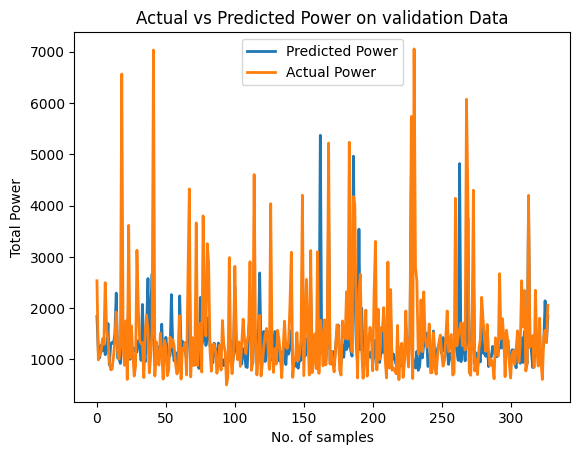

In [89]:
plt.plot(predictions_validation_original, label='Predicted Power', linewidth=2)
plt.plot(actuals_validation_original, label='Actual Power', linewidth=2)
plt.title('Actual vs Predicted Power on validation Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  predicted_test = model(X_test.to(device)).to('cpu').detach().numpy()
predicted_test = predicted_test.squeeze()
predicted_original_test = scaler.inverse_transform(predicted_test)
predicted_original_test = predicted_original_test[:, -1]
actual_test = y_test.to('cpu').numpy().squeeze()
actual_original_test = scaler.inverse_transform(actual_test)
actual_original_test = actual_original_test[:, -1]
print(predicted_original_test.shape, actual_original_test.shape)

test_outcomes =  pd.DataFrame({'Predicted Power':predicted_original_test, 'Actual Power': actual_original_test})
test_outcomes['diff'] = abs(test_outcomes['Predicted Power'] - test_outcomes['Actual Power'])
test_outcomes['relative diff'] = test_outcomes['diff']/test_outcomes['Actual Power']
test_outcomes

In [ ]:
# train MAPE
test_outcomes['relative diff'].mean()*100.0

In [ ]:
# re-evaluating on the training data
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').detach().numpy()
predicted = predicted.squeeze()
predicted_power = predicted[:, -1]
actual_power = y_train.to('cpu').numpy()
actual_power = actual_power.squeeze()
actual_power = actual_power[:, -1]
predicted_power.shape, actual_power.shape

In [ ]:
plt.plot(predicted_power, label='Predicted Power')
plt.plot(actual_power, label='Actual Power')
plt.title('Actual vs Predicted Power on Training Data')
plt.xlabel('No. of samples')
plt.ylabel('Predictions')
plt.legend()
plt.show()

**Actual vs Predicted Power on Test Data**

In [ ]:
with torch.no_grad():
  predicted = model(X_test.to(device)).to('cpu').detach().numpy()
predicted = predicted.squeeze()   #remove singleton dimension
predicted_power_test = predicted[:, -1]
actual_power = y_test.to('cpu').numpy()
actual_power = actual_power.squeeze()   #remove singleton dimension
actual_power_test = actual_power[:, -1]
predicted_power_test.shape, actual_power_test.shape

In [ ]:
plt.plot(predicted_power_test, label='Predicted Power')
plt.plot(actual_power_test, label='Actual Power')
plt.title('Actual vs Predicted Power on Test Data')
plt.xlabel('No. of samples')
plt.ylabel('Predictions')
plt.legend()
plt.show()

**Plotting on the Original Scale - 1. Training Data**

In [ ]:
with torch.no_grad():
  predicted_train = model(X_train.to(device)).to('cpu').detach().numpy()
predicted_train = predicted_train.squeeze()
predicted_original_train = scaler.inverse_transform(predicted_train)
predicted_original_train = predicted_original_train[:, -1]
actual_train = y_train.to('cpu').numpy().squeeze()
actual_original_train = scaler.inverse_transform(actual_train)
actual_original_train = actual_original_train[:, -1]
predicted_original_train.shape, actual_original_train.shape


In [ ]:
df

In [ ]:
train_outcomes =  pd.DataFrame({'Predicted Power':predicted_original_train, 'Actual Power': actual_original_train})
train_outcomes['diff'] = abs(train_outcomes['Predicted Power'] - train_outcomes['Actual Power'])
train_outcomes['relative diff'] = train_outcomes['diff']/train_outcomes['Actual Power']
train_outcomes

In [ ]:
train_outcomes.to_csv('Train Outcomes.csv')

In [ ]:
# train MAPE
train_outcomes['relative diff'].mean()*100.0

In [ ]:
plt.plot(predicted_original_train, label='Predicted Power')
plt.plot(actual_original_train, label='Actual Power')
plt.title('Actual vs Predicted Power on Training Data')
plt.xlabel('No. of samples')
plt.ylabel('Predictions')
plt.legend()
plt.show()

**Plotting on the Original Scale - 2. Test Data**

In [ ]:
model.eval()
total_mape_test = 0.0
with torch.no_grad():
  for batch_X_test, batch_y_test in test_loader:
    batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
    predictions_test = model(batch_X_test)

    # Compute MAPE
    mape = torch.mean(torch.abs((predictions_test - batch_y_test) / (batch_y_test + 1e-8))) * 100.0
    total_mape_test += mape.item()


  predicted = model(X_test.to(device)).to('cpu').detach().numpy()
predicted = predicted.squeeze()
predicted_original = scaler.inverse_transform(predicted)
predicted_original = predicted_original[:, -1]
actual = y_test.to('cpu').numpy().squeeze()
actual_original = scaler.inverse_transform(actual)
actual_original = actual_original[:, -1]
predicted_original.shape, actual_original.shape


In [ ]:
# Set the model to evaluation mode
model.eval()
total_mape_test = 0.0
# Use no_grad to avoid computing gradients
with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        predictions_test = model(batch_X_test)

        # Compute MAPE
        mape = torch.mean(torch.abs((predictions_test - batch_y_test) / (batch_y_test + 1e-8))) * 100.0
        total_mape_test += mape.item()

# Calculate the average MAPE
average_mape_test = total_mape_test / len(test_loader)
print(f'Final Test MAPE: {average_mape_test:.2f}%')


In [ ]:
test_outcomes =  pd.DataFrame({'Predicted Power':predicted_original, 'Actual Power': actual_original})
test_outcomes['diff'] = abs(test_outcomes['Predicted Power'] - test_outcomes['Actual Power'])
test_outcomes['relative diff'] = test_outcomes['diff']/test_outcomes['Actual Power']
test_outcomes

In [ ]:
# train MAPE
test_outcomes['relative diff'].mean()*100.0

In [ ]:
plt.plot(predicted_original, label='Predicted Power')
plt.plot(actual_original, label='Actual Power')
plt.title('Actual vs Predicted Power on Test Data')
plt.xlabel('No. of samples')
plt.ylabel('Predictions')
plt.legend()
plt.show()

In [ ]:
test_outcomes.to_csv('Test Outcomes.csv')